# Librerias

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

import optuna
from sklearn.pipeline import Pipeline


# Exploración de Datos

In [ ]:
file_path = '../data/youtoxic_english_1000.csv'
df = pd.read_csv(file_path)

df.info()

In [ ]:
df.head()

In [ ]:
# Primero mostramos información sobre valores nulos en el dataset
print("Valores nulos por columna antes de la limpieza:")
print(df.isnull().sum())
print("\nTotal de filas antes de la limpieza:", len(df))

# Tratamiento de los Datos

In [ ]:
# Crear una nueva columna que sea True si alguna característica de odio es True en esa fila
# Filtramos las columnas que representan características de odio
hate_columns = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 
                'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 
                'IsReligiousHate', 'IsRadicalism']

# Generamos la columna `Any_Hate` verificando si alguna de estas columnas es True
df['Any_Hate'] = df[hate_columns].any(axis=1)


df = df[['Text', 'Any_Hate'] + hate_columns]

# Mostrar algunas filas para verificar la nueva columna
df.head()


In [ ]:
df = df[['Text', 'Any_Hate']]

In [ ]:
df.head()

In [ ]:
# Convertimos la columna booleana 'Any_Hate' a enteros para crear el histograma
df['Any_Hate'] = df['Any_Hate'].astype(int)

# Graficamos el histograma
df['Any_Hate'].hist()


In [ ]:
df.head()

# Modelos

## Regresión Logística

### Sin optimizar hiperparametros

In [ ]:
# Dividimos entre datos de prueba y datos de entrenamietno

# Preparamos X (textos) e y (etiquetas)
X = df['Text']
y = df['Any_Hate']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20,
    random_state=42,
    stratify=y  # Mantenemos la proporción de clases
)

print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

In [ ]:
print('\n=================== X_train ===================\n', X_train)
print('\n=================== X_test ===================\n', X_test)
print('\n=================== y_train ===================\n', y_train)
print('\n=================== y_test ===================\n', y_test)

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,  # Limitamos el número de características
    min_df=2,          # Ignoramos términos que aparecen en menos de 2 documentos
    stop_words='english'  # Removemos stopwords en inglés
)

# Transformamos los textos
X_train_vectorized = vectorizer.fit_transform(X_train)  # Campo original de texto en X_train
X_test_vectorized = vectorizer.transform(X_test)        # Campo original de texto en X_test


print("Dimensiones de la matriz de características de entrenamiento:", X_train_vectorized.shape)

In [ ]:
# Regresion logística

model = LogisticRegression(max_iter=1000, C=0.1, class_weight='balanced')
model.fit(X_train_vectorized, y_train)
print("Train acc:", model.score(X_train_vectorized, y_train))
print("Test acc:", model.score(X_test_vectorized, y_test))

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_vectorized)

# Generar el informe de clasificación para evaluar el modelo
report = classification_report(y_test, y_pred, target_names=['No Hate', 'Hate'])
print(report)

### Optuna

In [ ]:
from joblib import Memory
import os

# Specify a directory to cache intermediate results
memory_location = os.path.join(os.getcwd(), 'pipeline_cache')
memory = Memory(location=memory_location, verbose=0)

In [370]:
# Definir la función de optimización para Optuna
def objective(trial):
    # Sugerencias de Optuna para los hiperparámetros
    max_features = trial.suggest_int('max_features', 1000, 7000, step=1000)
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2)])
    C = trial.suggest_loguniform('C', 0.1, 10)
    max_iter = trial.suggest_categorical('max_iter', [500, 1000])

    # Configurar pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)),
        ('logreg', LogisticRegression(C=C, max_iter=max_iter, random_state=42))
    ], memory=memory)
    
    # Entrenar el modelo y hacer predicciones
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Evaluar el modelo con el F1-score ponderado
    score = f1_score(y_test, y_pred, average='weighted')
    return score

# Crear un estudio de Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Resultados de Optuna
print("Mejores parámetros:", study.best_params)
print("Mejor F1 ponderado:", study.best_value)

# Entrenamiento final con los mejores parámetros encontrados
best_params = study.best_params
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=best_params['max_features'], ngram_range=best_params['ngram_range'])),
    ('logreg', LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'], random_state=42))
], memory=memory)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Informe de clasificación final
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['No Hate', 'Hate']))

c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
C:\Users\maria\AppData\Local\Temp\ipykernel_43840\688825379.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
[I

Mejores parámetros: {'max_features': 1000, 'ngram_range': (1, 2), 'C': 0.6979495683650419, 'max_iter': 1000}
Mejor F1 ponderado: 0.7408932530883751
              precision    recall  f1-score   support

     No Hate       0.71      0.91      0.80       108
        Hate       0.84      0.57      0.68        92

    accuracy                           0.75       200
   macro avg       0.77      0.74      0.74       200
weighted avg       0.77      0.75      0.74       200



### Resultados

In [371]:
# Sin optimizar
P_train = model.predict(X_train_vectorized) # Predicciones sobre el conjunto de entrenamiento
P_test = model.predict(X_test_vectorized) # Predicciones sobre el conjunto de test

In [372]:
# Optuna
P_train = pipeline.predict(X_train)  # Predicciones sobre el conjunto de entrenamiento
P_test = pipeline.predict(X_test)    # Predicciones sobre el conjunto de test


==================================== Entrenamiento ====================================

[[0.93023256 0.06976744]
 [0.23513514 0.76486486]]


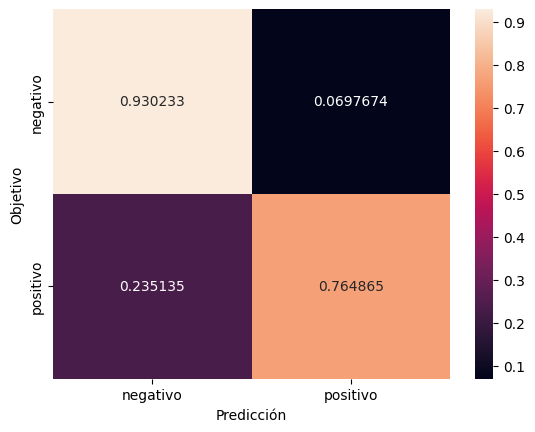

In [373]:
cm = confusion_matrix(y_train, P_train, normalize='true')

print("\n==================================== Entrenamiento ====================================\n")
print(cm)

def plot_cm(cm):
    classes = ['negativo', 'positivo']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Objetivo")
plot_cm(cm)


==================================== Test ====================================



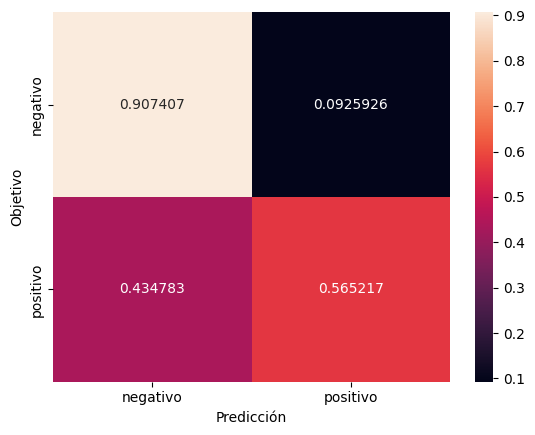

In [374]:
print("\n==================================== Test ====================================\n")

cm = confusion_matrix(y_test, P_test, normalize='true')
plot_cm(cm)

In [375]:
pipeline.named_steps['logreg'].coef_[0]

array([-5.12226748e-01, -4.12242129e-01, -4.20187371e-01, -2.34369428e-01,
       -3.42420195e-01,  1.13167732e-01, -3.59689890e-02,  6.53086015e-02,
        3.06727634e-01,  1.85684326e-01,  5.70691689e-02,  1.17921466e-01,
       -4.13791506e-01, -2.27992496e-01,  1.85251919e-01,  1.82571546e-01,
        1.42740353e-01,  1.25875461e-01,  3.71868236e-02, -1.18436674e-01,
        1.58685867e-01,  4.27871872e-01, -1.56154285e-01,  2.81025325e-01,
       -2.21065680e-01, -3.82119376e-01,  1.40090373e-01, -3.37812469e-01,
        9.79518237e-02, -1.23632154e-01, -3.47943263e-02, -2.24847477e-01,
        2.84236199e-01, -1.71220110e-01,  3.69460778e-01,  8.65830016e-01,
        6.33480305e-01,  4.87821878e-01, -5.66269513e-02,  1.29147568e-01,
       -8.64156414e-02, -1.92782424e-01,  1.77739941e-02,  1.47959669e-01,
       -8.73008184e-02, -6.47527046e-02,  2.11020452e-01,  5.85771465e-02,
        7.36197747e-02, -2.20159582e-02,  5.48959234e-02,  1.64864430e-01,
        1.48228558e-01,  

In [376]:
# Obtener el vocabulario del vectorizador dentro del pipeline
word_index_map = pipeline.named_steps['tfidf'].vocabulary_

corte = 4

print("Palabras más significativas de odio:")
for word, index in word_index_map.items():
    weight = pipeline.named_steps['logreg'].coef_[0][index]
    if weight > corte:
        print(word, weight)

Palabras más significativas de odio:


In [377]:
corte = 2.5

print("Palabras menos significativas de odio:")
for word, index in word_index_map.items():
    weight = pipeline.named_steps['logreg'].coef_[0][index]
    if weight < -corte:
        print(word, weight)

Palabras menos significativas de odio:


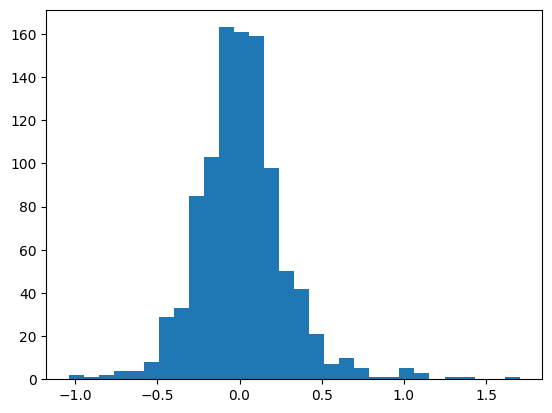

In [378]:
plt.hist(pipeline.named_steps['logreg'].coef_[0], bins=30);

## SVN

### Optuna

In [379]:
from sklearn.svm import SVC

# Convertir el texto en características numéricas usando TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limitar el número de características para simplificar
X_tfidf = tfidf.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Definir la función de optimización para Optuna
def objective(trial):
    # Sugerencias de Optuna para los hiperparámetros
    C = trial.suggest_loguniform('C', 0.1, 10)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    
    # `gamma` solo se usa para los kernels 'rbf' y 'poly'
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    else:
        gamma = 'scale'  # valor predeterminado para otros kernels
    
    # Configuración del modelo SVM con los hiperparámetros sugeridos
    model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    model.fit(X_train, y_train)
    
    # Predicciones y cálculo del F1 ponderado
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    return score

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Resultados de Optuna
print("Mejores parámetros:", study.best_params)
print("Mejor F1 ponderado:", study.best_value)

# Entrenamiento final con los mejores parámetros encontrados
best_params = study.best_params
best_model_SVC = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params.get('gamma', 'scale'), random_state=42)
best_model_SVC.fit(X_train, y_train)
y_pred = best_model_SVC.predict(X_test)

# Informe de clasificación final
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['No Hate', 'Hate']))

[I 2024-11-13 17:34:52,090] A new study created in memory with name: no-name-0344faeb-7bbc-4a69-864a-bbbd27c4d8c7
C:\Users\maria\AppData\Local\Temp\ipykernel_43840\1477835754.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
[I 2024-11-13 17:34:52,209] Trial 0 finished with value: 0.2951877133105802 and parameters: {'C': 2.6661655031206473, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.2951877133105802.
C:\Users\maria\AppData\Local\Temp\ipykernel_43840\1477835754.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
[I 2024-11-13 17:34:52,325] Trial 1 finished wit

Mejores parámetros: {'C': 1.808556354922278, 'kernel': 'linear'}
Mejor F1 ponderado: 0.6948856221405535
              precision    recall  f1-score   support

     No Hate       0.65      0.75      0.70        93
        Hate       0.75      0.64      0.69       107

    accuracy                           0.69       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.69      0.69       200



### Mejor modelo encontrado

In [380]:
final_svm_model = SVC(
    C=109.42844096035671,
    kernel='rbf',
    gamma=1.1662316858478285,
    probability=True,
    random_state=42,
    class_weight=None,
    tol=0.00043366566542372227,
    shrinking=False,
    max_iter=1697
)

# Entrenar el modelo con el conjunto de entrenamiento completo
final_svm_model.fit(X_train_vectorized, y_train)

print("Modelo final entrenado con los mejores hiperparámetros!")

Modelo final entrenado con los mejores hiperparámetros!


## MultinomialNB

In [381]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Definir la función objetivo para Optuna con MultinomialNB
def objective_nb(trial):
    # Definir los hiperparámetros a optimizar
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)  # Parámetro de suavizado
    fit_prior = trial.suggest_categorical('fit_prior', [True, False])  # Ajustar o no las probabilidades previas
    
    # Crear el modelo Naive Bayes con los hiperparámetros seleccionados
    nb_model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    
    # Evaluar el modelo con validación cruzada
    scores = cross_val_score(nb_model, X_train_vectorized, y_train, cv=3, scoring='accuracy')
    accuracy = scores.mean()  # Promedio de accuracy
    
    return accuracy  # Optuna maximiza este valor

# Crear un estudio de optimización para MultinomialNB
study_nb = optuna.create_study(direction='maximize')
study_nb.optimize(objective_nb, n_trials=50)  # Ajusta el número de pruebas según el tiempo disponible

# Resultados de la mejor prueba para MultinomialNB
print("Mejores hiperparámetros para MultinomialNB:")
print(study_nb.best_trial.params)
print("Mejor precisión:", study_nb.best_trial.value)

[I 2024-11-13 17:34:59,474] A new study created in memory with name: no-name-6a31a9b5-e906-4a94-baba-ebf5e31f124e
C:\Users\maria\AppData\Local\Temp\ipykernel_43840\158535209.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)  # Parámetro de suavizado
[I 2024-11-13 17:34:59,490] Trial 0 finished with value: 0.5162625665286812 and parameters: {'alpha': 0.027033425467696052, 'fit_prior': True}. Best is trial 0 with value: 0.5162625665286812.
C:\Users\maria\AppData\Local\Temp\ipykernel_43840\158535209.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)  # Parámetro de 

Mejores hiperparámetros para MultinomialNB:
{'alpha': 7.7545376851906855, 'fit_prior': True}
Mejor precisión: 0.5587564416659627


In [382]:
# Extraer los mejores hiperparámetros del estudio de MultinomialNB
best_params_nb = study_nb.best_trial.params

# Crear el modelo final con los mejores hiperparámetros
final_nb_model = MultinomialNB(
    alpha=best_params_nb['alpha'],
    fit_prior=best_params_nb['fit_prior']
)

# Entrenar el modelo con el conjunto de entrenamiento completo
final_nb_model.fit(X_train_vectorized, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_nb = final_nb_model.predict(X_test_vectorized)

# Calcular y mostrar la precisión y el reporte de clasificación
from sklearn.metrics import accuracy_score, classification_report
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)

print("Accuracy en conjunto de prueba para MultinomialNB:", accuracy_nb)
print("Reporte de clasificación para MultinomialNB:\n", report_nb)

Accuracy en conjunto de prueba para MultinomialNB: 0.465
Reporte de clasificación para MultinomialNB:
               precision    recall  f1-score   support

           0       0.47      1.00      0.63        93
           1       0.00      0.00      0.00       107

    accuracy                           0.47       200
   macro avg       0.23      0.50      0.32       200
weighted avg       0.22      0.47      0.30       200



c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

## RandomForestClassifier

In [383]:
from sklearn.ensemble import RandomForestClassifier

# Definir la función objetivo para Optuna con RandomForestClassifier
def objective_rf(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 300)  # Número de árboles
    max_depth = trial.suggest_int('max_depth', 5, 50)  # Profundidad máxima de cada árbol
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Tamaño mínimo para hacer split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Tamaño mínimo de muestras en una hoja
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])  # Características a considerar
    
    # Crear el modelo Random Forest con los hiperparámetros seleccionados
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Evaluar el modelo con validación cruzada
    scores = cross_val_score(rf_model, X_train_vectorized, y_train, cv=3, scoring='accuracy')
    accuracy = scores.mean()  # Promedio de accuracy
    
    return accuracy  # Optuna maximiza este valor

# Crear un estudio de optimización para RandomForestClassifier
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)  # Ajusta el número de pruebas según el tiempo disponible

# Resultados de la mejor prueba para RandomForestClassifier
print("Mejores hiperparámetros para RandomForestClassifier:")
print(study_rf.best_trial.params)
print("Mejor precisión:", study_rf.best_trial.value)

[I 2024-11-13 17:35:00,367] A new study created in memory with name: no-name-0f0bbc32-8488-44d9-8922-0970668002b2
[I 2024-11-13 17:35:01,154] Trial 0 finished with value: 0.5562501760018023 and parameters: {'n_estimators': 213, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.5562501760018023.
[I 2024-11-13 17:35:01,894] Trial 1 finished with value: 0.569954849670994 and parameters: {'n_estimators': 109, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.569954849670994.
[I 2024-11-13 17:35:02,940] Trial 2 finished with value: 0.5562501760018023 and parameters: {'n_estimators': 284, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.569954849670994.
[I 2024-11-13 17:35:03,716] Trial 3 finished with value: 0.5499892052227948 and parameters: {'n_estimators': 182, 'max_depth': 49, 'min_

Mejores hiperparámetros para RandomForestClassifier:
{'n_estimators': 124, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
Mejor precisión: 0.5699736231965683


In [384]:
# Crear el modelo final con los mejores hiperparámetros
final_rf_model = RandomForestClassifier(
    n_estimators=235,
    max_depth=44,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento completo
final_rf_model.fit(X_train_vectorized, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_rf = final_rf_model.predict(X_test_vectorized)

# Calcular y mostrar la precisión y el reporte de clasificación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("Accuracy en conjunto de prueba para RandomForestClassifier:", accuracy_rf)
print("Reporte de clasificación para RandomForestClassifier:\n", report_rf)

Accuracy en conjunto de prueba para RandomForestClassifier: 0.505
Reporte de clasificación para RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.48      0.75      0.59        93
           1       0.57      0.29      0.39       107

    accuracy                           0.51       200
   macro avg       0.53      0.52      0.49       200
weighted avg       0.53      0.51      0.48       200



## Ensemble

In [385]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import sparse
from sklearn.ensemble import VotingClassifier


# 1. Primero dividimos los datos en conjuntos de entrenamiento y prueba
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.01,
    random_state=42,
    stratify=y
)

# Separamos el conjunto temporal en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1,
    random_state=42,
    stratify=y_temp
)

# 2. Vectorizamos los datos
vectorizer_2 = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    max_features=5000
)

# Vectorizamos cada conjunto por separado
X_train_vectorized_2 = vectorizer_2.fit_transform(X_train)
X_val_vectorized = vectorizer_2.transform(X_val)
X_test_vectorized_2 = vectorizer_2.transform(X_test)

# Reducir dimensionalidad
selector = SelectKBest(score_func=chi2, k=1000)
X_train_reduced = selector.fit_transform(X_train_vectorized_2, y_train)
X_val_reduced = selector.transform(X_val_vectorized)
X_test_reduced = selector.transform(X_test_vectorized_2)

print("Dimensiones después de la reducción:")
print("Entrenamiento:", X_train_reduced.shape)
print("Validación:", X_val_reduced.shape)
print("Prueba:", X_test_reduced.shape)

# Integración de MLflow
import mlflow
mlflow.set_experiment("my-experiment")

with mlflow.start_run():
    mlflow.log_params({
        "max_depth": 5,
        "n_estimators": 100,
        "learning_rate": 0.1
    })

    # 4. Creamos y entrenamos el ensemble con bagging
    bagged_ensemble = BaggingClassifier(
        estimator=VotingClassifier(
            estimators=[
                ('random_forest', final_rf_model),
                ('naive_bayes', final_nb_model),
                ('svm', final_svm_model)
            ],
            voting='soft'
        ),
        n_estimators=10,
        max_samples=0.8,
        max_features=0.8,
        random_state=42
    )

    # 5. Implementamos early stopping
    class EarlyStoppingMonitor:
        def __init__(self, patience=3, min_delta=0.001):
            self.patience = patience
            self.min_delta = min_delta
            self.best_score = None
            self.counter = 0
            self.best_model = None
            
        def check(self, model, val_score):
            if self.best_score is None or val_score > self.best_score + self.min_delta:
                self.best_score = val_score
                self.counter = 0
                self.best_model = model
                return False
            else:
                self.counter += 1
                return self.counter >= self.patience

    # Entrenamiento con early stopping
    monitor = EarlyStoppingMonitor(patience=3)
    best_accuracy = 0

    for epoch in range(10):
        # Entrenar el modelo
        bagged_ensemble.fit(X_train_reduced, y_train)
        
        # Evaluar en el conjunto de validación
        val_accuracy = bagged_ensemble.score(X_val_reduced, y_val)
        print(f"Época {epoch + 1}, Accuracy en validación: {val_accuracy:.4f}")
        
        if monitor.check(bagged_ensemble, val_accuracy):
            print("Early stopping activado en época", epoch + 1)
            break

    # Usar el mejor modelo encontrado
    best_model = monitor.best_model if monitor.best_model is not None else bagged_ensemble

Dimensiones después de la reducción:
Entrenamiento: (891, 1000)
Validación: (99, 1000)
Prueba: (10, 1000)


c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\

Época 1, Accuracy en validación: 0.7677


c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\

Época 2, Accuracy en validación: 0.7677


c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\

Época 3, Accuracy en validación: 0.7677


c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Época 4, Accuracy en validación: 0.7677
Early stopping activado en época 4


c:\Users\maria\MROSA\BOOTCAMP IA\Proyectos\Proyecto_15_NLP_Sentimientos\Detector_de_odio_G8\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1697).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [386]:
# Evaluar el mejor modelo con threshold
threshold = 0.59

# Predicciones en entrenamiento
y_prob_train = best_model.predict_proba(X_train_reduced)[:, 1]
y_pred_train_thresholded = (y_prob_train >= threshold).astype(int)

# Predicciones en prueba
y_prob_test = best_model.predict_proba(X_test_reduced)[:, 1]
y_pred_test_thresholded = (y_prob_test >= threshold).astype(int)

# Calcular métricas
accuracy_train = accuracy_score(y_train, y_pred_train_thresholded)
accuracy_test = accuracy_score(y_test, y_pred_test_thresholded)
overfitting_percentage = ((accuracy_train - accuracy_test) / accuracy_train) * 100

# Imprimir resultados
print("\nResultados finales:")
print(f"Accuracy en entrenamiento (threshold={threshold}): {accuracy_train:.4f}")
print(f"Accuracy en prueba (threshold={threshold}): {accuracy_test:.4f}")
print(f"Porcentaje de overfitting: {overfitting_percentage:.2f}%")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_test_thresholded))

# Visualizar las características más importantes
if hasattr(selector, 'get_feature_names_out'):
    feature_names = vectorizer_2.get_feature_names_out()
    selected_features = selector.get_support()
    important_features = [(feature_names[i], selector.scores_[i]) 
                         for i in range(len(feature_names)) 
                         if selected_features[i]]
    
    important_features.sort(key=lambda x: x[1], reverse=True)
    print("\nTop 10 características más importantes:")
    for feature, score in important_features[:10]:
        print(f"{feature}: {score:.4f}")


Resultados finales:
Accuracy en entrenamiento (threshold=0.59): 0.7587
Accuracy en prueba (threshold=0.59): 0.8000
Porcentaje de overfitting: -5.44%

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10


Top 10 características más importantes:
run: 8.1457
fuck: 7.1270
over: 6.6136
them: 5.8197
idiot: 5.2509
shit: 5.2149
ass: 5.1603
peggy: 4.8790
fucking: 4.6901
bitch: 4.6859


# Prueba de los Modelos

#### Colores

In [387]:
# Definición de colores, estilos e iconos
BRIGHT_GREEN = "\033[92m"
ITALIC = "\033[3m"
BG_BLACK = "\033[40m"
RESET = "\033[0m"
TAXI = "\U0001F696"          # 🚖
FLAG = "\U0001F3C1"          # 🏁
GREEN_CIRCLE = "\U0001F7E2"  # 🟢
RED_CIRCLE = "\U0001F534"    # 🔴
CROSS_MARK = "\U0000274C"    # ❌
STAR = "\U00002B50"          # ⭐
DESTINATION_FLAG = "\U0001F3C1"  # 🏁
LOCATION_MARKER = "\U0001F4CD"   # 📍
CELEBRATION = "\U0001F389"       # 🎉
SMILE = "\U0001F600"     # 😀
THINKING = "\U0001F914"  # 🤔
EYE = "\U0001F441"  # 👁️
RED = "\033[31m"
WHITE = "\033[37m"  # Definición del color blanco
LOCK = "\U0001F512"  # 🔒

## Class AnalizadorTexto

In [388]:
class AnalizadorTexto:
    def __init__(self, bagged_ensemble, tfidf_vectorizer):
        # Inicializa los atributos con el modelo y el vectorizador
        self.bagged_ensemble = bagged_ensemble
        self.tfidf_vectorizer = tfidf_vectorizer
        
    def logistic_regression_optuna(self, textos):
        # Verificar que el argumento sea una lista
        if not isinstance(textos, list):
            raise TypeError("El argumento debe ser una lista de cadenas de texto.")
        
        # Realiza la predicción en la lista completa usando el pipeline de regresion logistica
        P = pipeline.predict(textos)

        # Obtener las clases del modelo
        clases = pipeline.classes_

        # Procesar y mostrar la clase predicha para cada texto
        resultados = []
        for i, texto in enumerate(textos):
            if clases[P[i]] == 0:
                resultado = f"\n'{texto}'\n{SMILE}{BRIGHT_GREEN} No es un mensaje de odio{RESET}"
            else:
                resultado = f"\n'{texto}'\n{CROSS_MARK}{RED} Es un mensaje de odio{RESET}"
            resultados.append(resultado)
            print(resultado)  # Mostrar el resultado en la consola
        
        return resultados

    def svc_optuna(self, textos):
        # Verificar que el argumento sea una lista
        if not isinstance(textos, list):
            raise TypeError("El argumento debe ser una lista de cadenas de texto.")
        
        # Transformar los textos con el mismo vectorizador TF-IDF que se usó en el entrenamiento
        textos_transformados = tfidf.transform(textos)

        # Realizar la predicción en la lista completa usando el modelo SVC optimizado
        P = best_model_SVC.predict(textos_transformados)

        # Asumimos que las clases son [0: No Hate, 1: Hate]
        clases = [0, 1]

        # Procesar y mostrar la clase predicha para cada texto
        resultados = []
        for i, texto in enumerate(textos):
            if P[i] == 0:
                resultado = f"\n'{texto}'\n{SMILE}{BRIGHT_GREEN} No es un mensaje de odio{RESET}"
            else:
                resultado = f"\n'{texto}'\n{CROSS_MARK}{RED} Es un mensaje de odio{RESET}"
            resultados.append(resultado)
            print(resultado)  # Mostrar el resultado en la consola
        
        return resultados
    
    def ensemble_prediction(self, textos):
        # Verificar que el argumento sea una lista
        if not isinstance(textos, list):
            raise TypeError("El argumento debe ser una lista de cadenas de texto.")

        # Vectorizar el texto
        x_tfidf = tfidf.transform(textos)  # Asegúrate de que 'tfidf' esté definido globalmente

        # Realizar predicciones usando el modelo de ensamble
        P = self.bagged_ensemble.predict(x_tfidf)

        # Procesar y mostrar la clase predicha para cada texto
        resultados = []
        for i, texto in enumerate(textos):
            if P[i] == 0:
                resultado = f"'{texto}'\nNo es un mensaje de odio"
            else:
                resultado = f"'{texto}'\nEs un mensaje de odio"
            resultados.append(resultado)
            print(resultado)  # Mostrar el resultado en la consola

        return resultados


In [389]:
# Crear una instancia de la clase y probarla
analizador = AnalizadorTexto(bagged_ensemble=bagged_ensemble, tfidf_vectorizer=tfidf)
prueba = [
    "fuck you",
    "People who believe in those protests are idiots.",
    "shit",
    "Some groups think they are above the law, but they’re not."
]

## Pruebas

### Regresión Logística Optuna

In [390]:
# Logistic Regression Optuna
print(f"======================== {STAR} Resultados con Logistic Regression Optuna {STAR} ========================")
resultados_log_reg_optuna = analizador.logistic_regression_optuna(prueba)

======================== ⭐ Resultados con Logistic Regression Optuna ⭐ ========================

'fuck you'
❌ Es un mensaje de odio

'People who believe in those protests are idiots.'
❌ Es un mensaje de odio

'shit'
❌ Es un mensaje de odio

'Some groups think they are above the law, but they’re not.'
😀 No es un mensaje de odio


### SVC Optuna

In [391]:
# SVC Optuna
print(f"======================== {STAR} Resultados con SVC Optuna {STAR} ========================")
resultados_svc_optuna = analizador.svc_optuna(prueba)

======================== ⭐ Resultados con SVC Optuna ⭐ ========================

'fuck you'
❌ Es un mensaje de odio

'People who believe in those protests are idiots.'
❌ Es un mensaje de odio

'shit'
❌ Es un mensaje de odio

'Some groups think they are above the law, but they’re not.'
😀 No es un mensaje de odio


### Ensemble

In [392]:
# Ensemble
print(f"======================== {STAR} Resultados con Ensemble {STAR} ========================")
resultados = analizador.ensemble_prediction(prueba)

======================== ⭐ Resultados con Ensemble ⭐ ========================


ValueError: X has 4576 features, but BaggingClassifier is expecting 1000 features as input.

# Exportar modelo final entrenado

In [ ]:
import joblib

# Guardar el vectorizador
joblib.dump(vectorizer_2, 'vectorizer_2.pkl')

# Guardar el selector de características
joblib.dump(selector, 'feature_selector.pkl')

# Guardar el modelo entrenado
joblib.dump(best_model, 'ensemble_model.pkl')